Reference: https://www.kaggle.com/code/finlay/shopee-products-matching-image-part-english

In [1]:
import numpy as np
import pandas as pd
import imagehash
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import gc

In [2]:
DATA_PATH = '../input/shopee-product-matching/'

train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
target_mapping = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(target_mapping)

In [3]:
train = train.sort_values(by='label_group')
train.head()

,posting_id,image,image_phash,title,label_group,target
3874,train_1646767365,../input/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,"[train_1646767365, train_398181303, train_1528..."
31859,train_1528423085,../input/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047,"[train_1646767365, train_398181303, train_1528..."
6738,train_398181303,../input/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047,"[train_1646767365, train_398181303, train_1528..."
7613,train_2865605743,../input/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977,"[train_2865605743, train_1382500866]"
12367,train_1382500866,../input/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977,"[train_2865605743, train_1382500866]"


# 1 Image Hash

https://github.com/jenssegers/imagehash


four different hash methods:
* average hashing (aHash)
* perception hashing (pHash)
* difference hashing (dHash)
* wavelet hashing (wHash)



In [4]:
ahash = imagehash.average_hash(Image.open(train['image'].iloc[0]))
ahash

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True, False, False, False,  True,  True],
       [ True,  True, False, False, False, False,  True,  True],
       [ True,  True, False, False, False, False,  True,  True],
       [ True,  True, False, False, False, False, False,  True],
       [ True,  True, False, False, False, False, False,  True],
       [ True, False,  True,  True, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True, False,  True]])

In [5]:
# conver to string
str(ahash)

'ff23c3c3c1c1b1fd'

In [6]:
print("ahash:", str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print("phash:", str(imagehash.phash(Image.open(train['image'].iloc[0]))))
print("dhash:", str(imagehash.dhash(Image.open(train['image'].iloc[0]))))
print("whash:", str(imagehash.whash(Image.open(train['image'].iloc[0]))))

ahash: ff23c3c3c1c1b1fd
phash: e925873ed09cd08f
dhash: 6f4f171713232351
whash: f703c3c3c1c181fd


In [7]:
print("ahash of three images from the same group:")
print(str(imagehash.average_hash(Image.open(train['image'].iloc[0]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[1]))))
print(str(imagehash.average_hash(Image.open(train['image'].iloc[2]))))

ahash of three images from the same group:
ff23c3c3c1c1b1fd
bfffe1c1c181f1fd
e7e3c3c3c1c181fd


# 2 Color Hist

Populating the interactive namespace from numpy and matplotlib


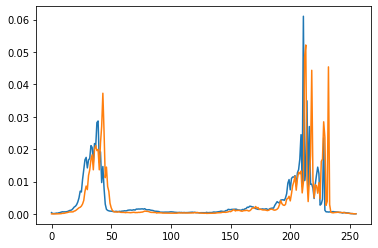

In [8]:
%pylab inline

def cal_hist(path):
    img = cv2.imread(path, 0)  # here uses grey scale image
    # https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html
    arr = cv2.calcHist([img], [0], None, [256], [0, 256])
    arr = arr.reshape(-1)
    return arr / arr.sum()

# same group:
plt.plot(range(256), cal_hist(train['image'].iloc[0]))
plt.plot(range(256), cal_hist(train['image'].iloc[2]))

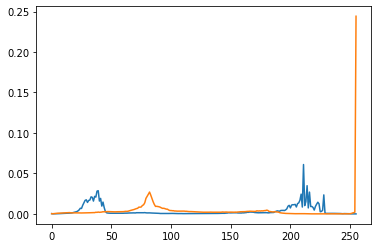

In [9]:
# different groups:
plt.plot(range(256), cal_hist(train['image'].iloc[0]))
plt.plot(range(256), cal_hist(train['image'].iloc[10]))

# 3 Image Keypoint

https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

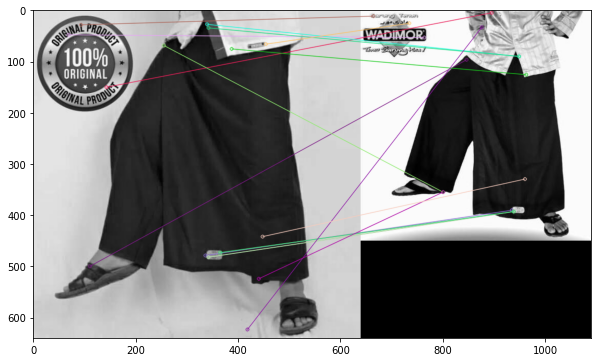

(<matplotlib.image.AxesImage at 0x7f789d59da10>, None)

In [10]:
img1 = cv2.imread(train['image'].iloc[0], 0)  # queryImage
img2 = cv2.imread(train['image'].iloc[1], 0)  # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


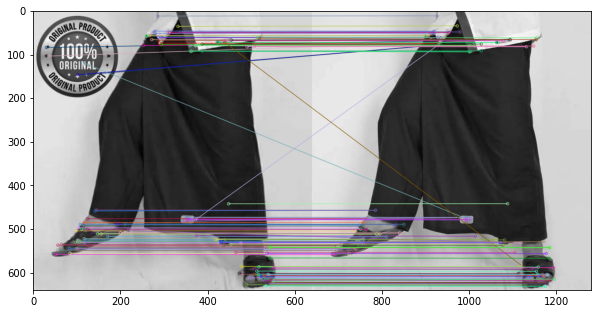

(<matplotlib.image.AxesImage at 0x7f789d51fc10>, None)

In [11]:
img1 = cv2.imread(train['image'].iloc[0], 0)  # queryImage
img2 = cv2.imread(train['image'].iloc[2], 0)  # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()


In [12]:
# a function for sift distance
def sift_match(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create(300)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    return len(good)

In [13]:
# same group
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 249114794]['image'].iloc[1])

30

In [14]:
# different groups
sift_match(train[train['label_group'] == 249114794]['image'].iloc[0],
            train[train['label_group'] == 258047]['image'].iloc[1])

15

# 4 CNN